In [ ]:
import os, shutil
import zipfile
import random
from random import sample
import shutil
from shutil import copyfile
import pathlib
from pathlib import Path
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm as tq

%matplotlib inline
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.image import imread

import cv2
from PIL import Image
import skimage
from skimage import io
from skimage.transform import resize
from skimage.transform import rotate, AffineTransform, warp
from skimage import img_as_ubyte
from skimage.exposure import adjust_gamma
from skimage.util import random_noise

import keras
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay
import tensorflow as tf
from tensorflow.keras import Model, layers
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from tensorflow.keras.optimizers import Adam, RMSprop, SGD
from tensorflow.keras.layers import InputLayer, Conv2D, SeparableConv2D, MaxPooling2D, MaxPool2D, Dense, Flatten, Dropout, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.applications.densenet import DenseNet121
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ModelCheckpoint, Callback, EarlyStopping, ReduceLROnPlateau

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# **Data Loading**

In [ ]:
!curl -L -o garbage-classification-v2.zip\
  "https://www.kaggle.com/api/v1/datasets/download/sumn2u/garbage-classification-v2"

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100  744M  100  744M    0     0  78.0M      0  0:00:09  0:00:09 --:--:-- 41.5M


In [ ]:
!unzip garbage-classification-v2.zip

Streaming output truncated to the last 5000 lines.
  inflating: garbage-dataset/paper/paper_847.jpg  
  inflating: garbage-dataset/paper/paper_848.jpg  
  inflating: garbage-dataset/paper/paper_849.jpg  
  inflating: garbage-dataset/paper/paper_851.jpg  
  inflating: garbage-dataset/paper/paper_852.jpg  
  inflating: garbage-dataset/paper/paper_853.jpg  
  inflating: garbage-dataset/paper/paper_855.jpg  
  inflating: garbage-dataset/paper/paper_856.jpg  
  inflating: garbage-dataset/paper/paper_857.jpg  
  inflating: garbage-dataset/paper/paper_859.jpg  
  inflating: garbage-dataset/paper/paper_861.jpg  
  inflating: garbage-dataset/paper/paper_863.jpg  
  inflating: garbage-dataset/paper/paper_865.jpg  
  inflating: garbage-dataset/paper/paper_868.jpg  
  inflating: garbage-dataset/paper/paper_870.jpg  
  inflating: garbage-dataset/paper/paper_871.jpg  
  inflating: garbage-dataset/paper/paper_873.jpg  
  inflating: garbage-dataset/paper/paper_874.jpg  
  inflating: garbage-dataset/pa

# **Data Understanding**

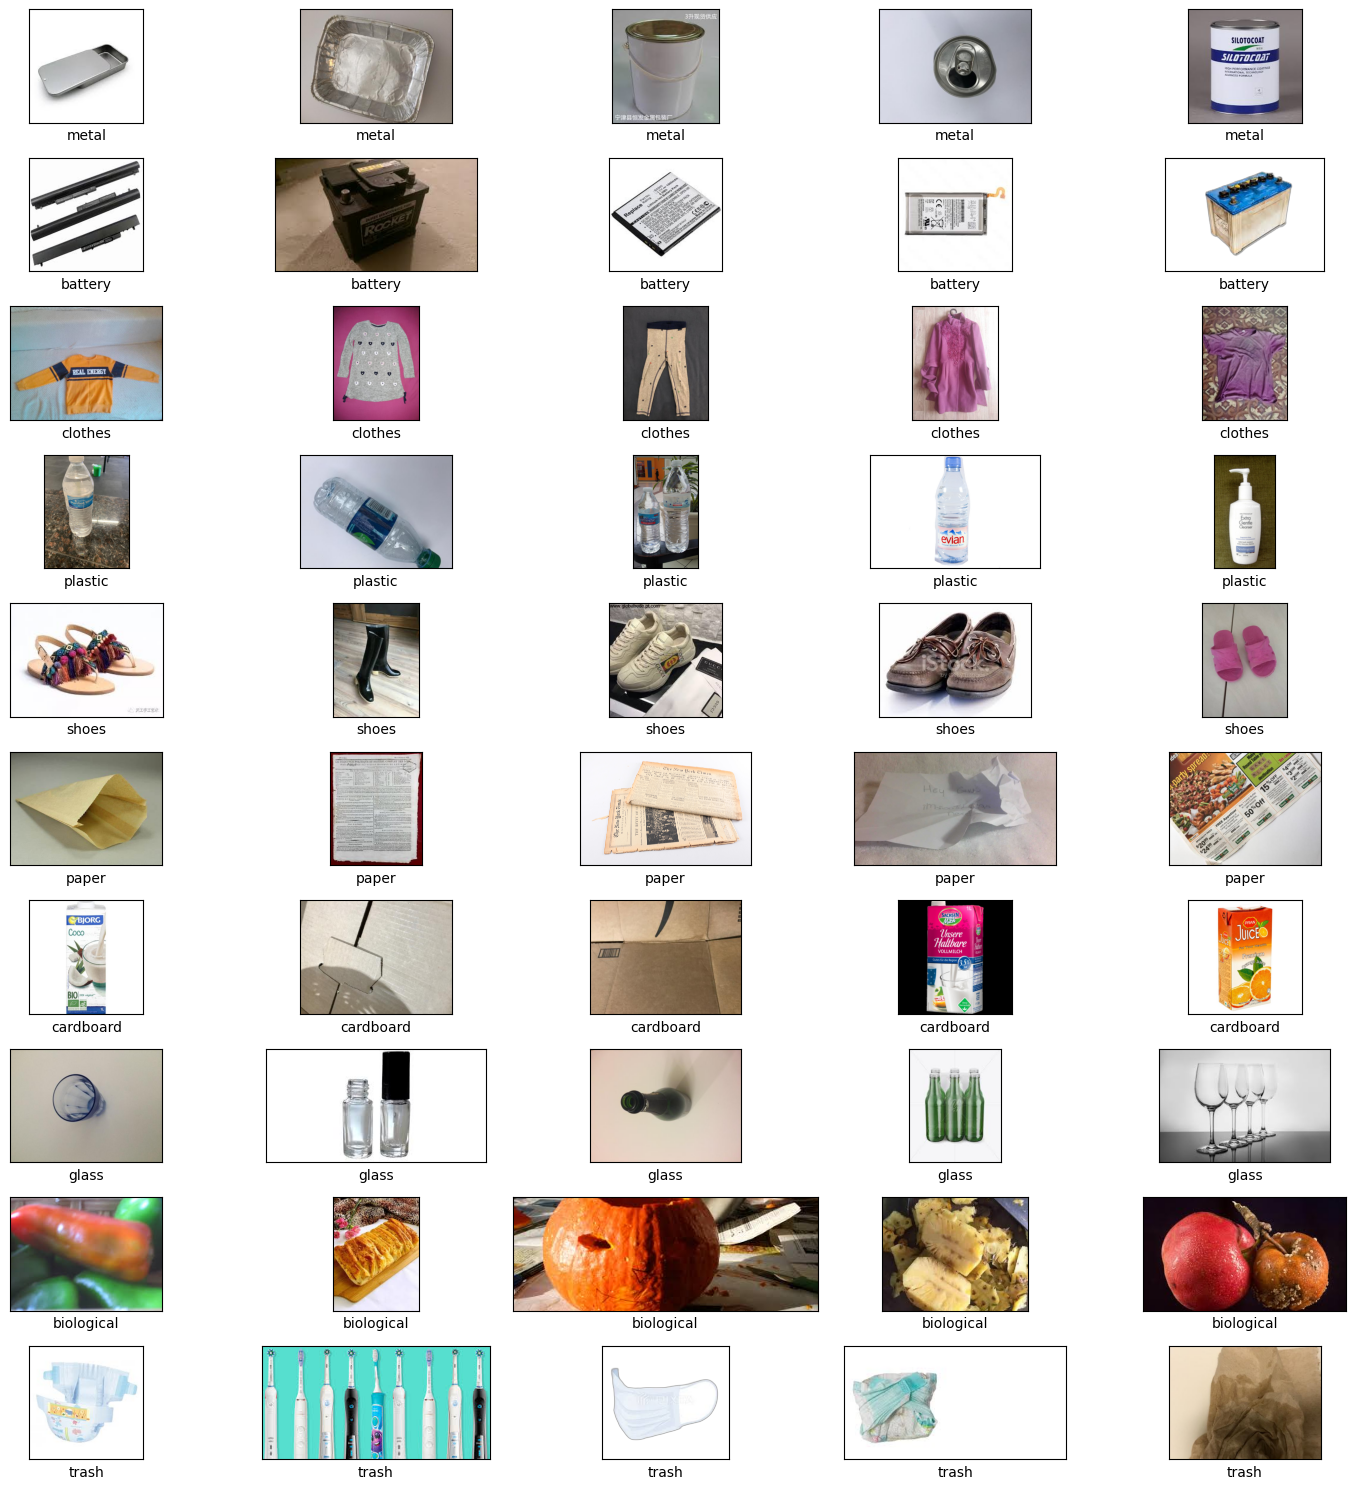

In [ ]:
# Membuat kamus yang menyimpan gambar untuk setiap kelas
garbage_img = {}

# Path ke folder garbage
path = "garbage-dataset"
for class_folder in os.listdir(path):
    garbage_img[class_folder] = os.listdir(os.path.join(path, class_folder))

# Menampilkan secara acak 5 gambar dari setiap kelas
fig, axs = plt.subplots(len(garbage_img.keys()), 5, figsize=(15, 15))

for i, class_name in enumerate(garbage_img.keys()):
    images = np.random.choice(garbage_img[class_name], 5, replace=False)

    for j, image_name in enumerate(images):
        img_path = os.path.join(path, class_name, image_name)
        img = Image.open(img_path)
        axs[i, j].imshow(img)
        axs[i, j].set(xlabel=class_name, xticks=[], yticks=[])

fig.tight_layout()

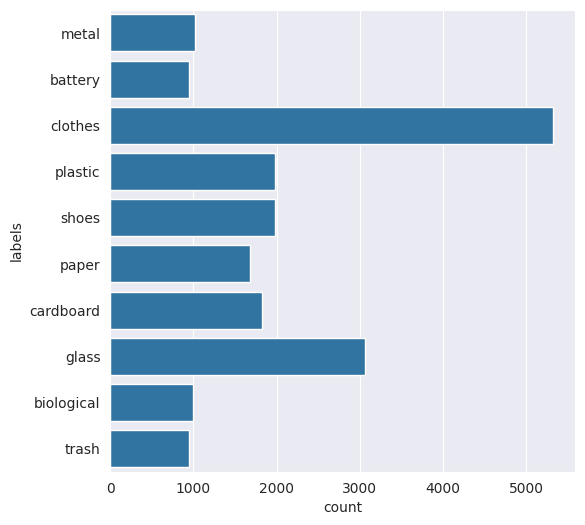

In [ ]:
# Define source path
garbage_path = "garbage-dataset"

# Create a list that stores data for each filenames, filepaths, and labels in the data
file_name = []
labels = []
full_path = []

# Get data image filenames, filepaths, labels one by one with looping, and store them as dataframe
for path, subdirs, files in os.walk(garbage_path):
    for name in files:
        full_path.append(os.path.join(path, name))
        labels.append(path.split('/')[-1])
        file_name.append(name)

distribution_train = pd.DataFrame({"path":full_path,'file_name':file_name,"labels":labels})

# Plot the distribution of images across the classes
Label = distribution_train['labels']
plt.figure(figsize = (6,6))
sns.set_style("darkgrid")
plot_data = sns.countplot(Label)

In [ ]:
def get_image_resolution(filepath):
    with Image.open(filepath) as img:
        return img.size

dataset_path = "garbage-dataset"

data = []

for root, _, files in os.walk(dataset_path):
    for file in files:
        if file.lower().endswith(('.jpg', '.jpeg', '.png')):
            file_path = os.path.join(root, file)
            label = os.path.basename(os.path.dirname(file_path))  # <-- ini
            data.append({
                'filename': file,
                'filepath': file_path,
                'label': label
            })

dataset_df = pd.DataFrame(data)

dataset_df['resolution'] = dataset_df['filepath'].apply(get_image_resolution)
dataset_df[['width', 'height']] = pd.DataFrame(dataset_df['resolution'].tolist(), index=dataset_df.index)

dataset_df['aspect_ratio'] = dataset_df['width'] / dataset_df['height']

dataset_df.head()

,filename,filepath,label,resolution,width,height,aspect_ratio
0,metal_2618.jpg,garbage-dataset/metal/metal_2618.jpg,metal,"(600, 450)",600,450,1.333333
1,metal_934.jpg,garbage-dataset/metal/metal_934.jpg,metal,"(474, 355)",474,355,1.335211
2,metal_2442.jpg,garbage-dataset/metal/metal_2442.jpg,metal,"(474, 474)",474,474,1.000000
3,metal_2417.jpg,garbage-dataset/metal/metal_2417.jpg,metal,"(512, 384)",512,384,1.333333
4,metal_2158.jpg,garbage-dataset/metal/metal_2158.jpg,metal,"(512, 384)",512,384,1.333333


In [ ]:
dataset_df['resolution'].value_counts()

,count
resolution,
"(400, 533)",2591
"(512, 384)",2524
"(225, 225)",1924
"(400, 534)",1077
"(275, 183)",671
...,...
"(450, 112)",1
"(240, 195)",1
"(441, 114)",1


# **Data Splitting**

In [ ]:
X= dataset_df['filepath']
y= dataset_df['label']

X_temp, X_test, y_temp, y_test = train_test_split(
    X, y, test_size=0.3, random_state=300)

X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp, test_size=0.3, random_state=300)

In [ ]:
df_train = pd.DataFrame({'filepath':X_train,'label':y_train,'set':'train'})
df_test = pd.DataFrame({'filepath':X_test,'label':y_test,'set':'test'})
df_val = pd.DataFrame({'filepath':X_test,'label':y_test,'set':'val'})

In [ ]:
print('train size', len(df_train))
print('test size', len(df_test))
print('val size', len(df_val))

train size 9683
test size 5929
val size 5929


In [ ]:
df_all = pd.concat([df_train, df_test, df_val], ignore_index=True)

print('===================================================== \n')
print(df_all.groupby(['set', 'label']).size(), '\n')
print('===================================================== \n')

print(df_all.sample(5))


set    label     
test   battery        277
       biological     296
       cardboard      568
       clothes       1602
       glass          920
       metal          306
       paper          470
       plastic        652
       shoes          575
       trash          263
train  battery        456
       biological     481
       cardboard      870
       clothes       2636
       glass         1508
       metal          519
       paper          838
       plastic        934
       shoes          974
       trash          467
val    battery        277
       biological     296
       cardboard      568
       clothes       1602
       glass          920
       metal          306
       paper          470
       plastic        652
       shoes          575
       trash          263
dtype: int64 


                                             filepath    label    set
1623  garbage-dataset/trash/trash_20240626_165745.jpg    trash  train
7977              garbage-dataset/shoes/shoes

In [ ]:
# Memanggil dataset asli yang berisi keseluruhan data gambar yang sesuai dengan labelnya
datasource_path = "dataset/"
# Membuat variabel Dataset, dimana nanti menampung data yang telah dilakukan pembagian data training dan testing
dataset_path = "Dataset-Final/"

In [ ]:
for index, row in tq(df_all.iterrows()):
    # Deteksi filepath
    file_path = row['filepath']
    if os.path.exists(file_path) == False:
            file_path = os.path.join(datasource_path,row['label'],row['image'].split('.')[0])

    # Buat direktori tujuan folder
    if os.path.exists(os.path.join(dataset_path,row['set'],row['label'])) == False:
        os.makedirs(os.path.join(dataset_path,row['set'],row['label']))

    # Tentukan tujuan file
    destination_file_name = file_path.split('/')[-1]
    file_dest = os.path.join(dataset_path,row['set'],row['label'],destination_file_name)

    # Salin file dari sumber ke tujuan
    if os.path.exists(file_dest) == False:
        shutil.copy2(file_path,file_dest)

0it [00:00, ?it/s]

# **Image Data Generator**

In [ ]:
train_dir = "Dataset-Final/train"
test_dir = "Dataset-Final/test"
val_dir = "Dataset-Final/val"


datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_gen = datagen.flow_from_directory(train_dir,
    batch_size=32,
    target_size=(224, 224),
    class_mode='categorical',
    shuffle=True
)

test_gen = test_datagen.flow_from_directory(test_dir,
    batch_size=1,
    target_size=(224, 224),
    class_mode='categorical',
    shuffle=False
)

val_gen = datagen.flow_from_directory(val_dir,
    batch_size=32,
    target_size=(224, 224),
    class_mode='categorical',
    shuffle=False
)

Found 9683 images belonging to 10 classes.
Found 5929 images belonging to 10 classes.
Found 5929 images belonging to 10 classes.


# **Modelling**

In [ ]:
base_model = MobileNet(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False

model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dropout(0.3),
    Dense(128, activation='relu'),
    Dropout(0.3),
    Dense(train_gen.num_classes, activation='softmax')
])

model.compile(optimizer=Adam(learning_rate=1e-4),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

17225924/17225924 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenet_1.00_224 (Functional) │ (None, 7, 7, 1024)     │     3,228,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1024)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       131,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,361,354 (12.82 MB)

 Trainable params: 132,490 (517.54 KB)

 Non-trainable params: 3,228,864 (12.32 MB)

In [ ]:
earlystop = EarlyStopping(patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(factor=0.2, patience=3)

checkpoint = ModelCheckpoint(
    'best_model.h5', monitor='val_accuracy', mode='max',
    save_best_only=True, verbose=1
)

history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=30,
    callbacks=[earlystop, reduce_lr, checkpoint]
)

Epoch 1/30


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


303/303 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step - accuracy: 0.3985 - loss: 1.9318
Epoch 1: val_accuracy improved from -inf to 0.79373, saving model to best_model.h5


303/303 ━━━━━━━━━━━━━━━━━━━━ 64s 183ms/step - accuracy: 0.3989 - loss: 1.9303 - val_accuracy: 0.7937 - val_loss: 0.7203 - learning_rate: 1.0000e-04
Epoch 2/30
303/303 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step - accuracy: 0.7085 - loss: 0.8848
Epoch 2: val_accuracy improved from 0.79373 to 0.85225, saving model to best_model.h5


303/303 ━━━━━━━━━━━━━━━━━━━━ 48s 159ms/step - accuracy: 0.7086 - loss: 0.8845 - val_accuracy: 0.8523 - val_loss: 0.4849 - learning_rate: 1.0000e-04
Epoch 3/30
303/303 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step - accuracy: 0.7808 - loss: 0.6530
Epoch 3: val_accuracy improved from 0.85225 to 0.87367, saving model to best_model.h5


303/303 ━━━━━━━━━━━━━━━━━━━━ 48s 158ms/step - accuracy: 0.7808 - loss: 0.6529 - val_accuracy: 0.8737 - val_loss: 0.3979 - learning_rate: 1.0000e-04
Epoch 4/30
303/303 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step - accuracy: 0.8182 - loss: 0.5503
Epoch 4: val_accuracy improved from 0.87367 to 0.88379, saving model to best_model.h5


303/303 ━━━━━━━━━━━━━━━━━━━━ 46s 152ms/step - accuracy: 0.8182 - loss: 0.5502 - val_accuracy: 0.8838 - val_loss: 0.3563 - learning_rate: 1.0000e-04
Epoch 5/30
303/303 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step - accuracy: 0.8378 - loss: 0.4909
Epoch 5: val_accuracy improved from 0.88379 to 0.89594, saving model to best_model.h5


303/303 ━━━━━━━━━━━━━━━━━━━━ 47s 154ms/step - accuracy: 0.8378 - loss: 0.4908 - val_accuracy: 0.8959 - val_loss: 0.3315 - learning_rate: 1.0000e-04
Epoch 6/30
303/303 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step - accuracy: 0.8559 - loss: 0.4466
Epoch 6: val_accuracy improved from 0.89594 to 0.90302, saving model to best_model.h5


303/303 ━━━━━━━━━━━━━━━━━━━━ 46s 152ms/step - accuracy: 0.8559 - loss: 0.4465 - val_accuracy: 0.9030 - val_loss: 0.3075 - learning_rate: 1.0000e-04
Epoch 7/30
303/303 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step - accuracy: 0.8726 - loss: 0.4050
Epoch 7: val_accuracy improved from 0.90302 to 0.90858, saving model to best_model.h5


303/303 ━━━━━━━━━━━━━━━━━━━━ 49s 161ms/step - accuracy: 0.8726 - loss: 0.4050 - val_accuracy: 0.9086 - val_loss: 0.2934 - learning_rate: 1.0000e-04
Epoch 8/30
303/303 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step - accuracy: 0.8797 - loss: 0.3654
Epoch 8: val_accuracy improved from 0.90858 to 0.91078, saving model to best_model.h5


303/303 ━━━━━━━━━━━━━━━━━━━━ 45s 147ms/step - accuracy: 0.8797 - loss: 0.3654 - val_accuracy: 0.9108 - val_loss: 0.2830 - learning_rate: 1.0000e-04
Epoch 9/30
303/303 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step - accuracy: 0.8836 - loss: 0.3571
Epoch 9: val_accuracy improved from 0.91078 to 0.91263, saving model to best_model.h5


303/303 ━━━━━━━━━━━━━━━━━━━━ 88s 168ms/step - accuracy: 0.8836 - loss: 0.3571 - val_accuracy: 0.9126 - val_loss: 0.2742 - learning_rate: 1.0000e-04
Epoch 10/30
303/303 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step - accuracy: 0.8859 - loss: 0.3361
Epoch 10: val_accuracy improved from 0.91263 to 0.91415, saving model to best_model.h5


303/303 ━━━━━━━━━━━━━━━━━━━━ 45s 148ms/step - accuracy: 0.8859 - loss: 0.3361 - val_accuracy: 0.9142 - val_loss: 0.2691 - learning_rate: 1.0000e-04
Epoch 11/30
303/303 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step - accuracy: 0.8977 - loss: 0.3219
Epoch 11: val_accuracy improved from 0.91415 to 0.91634, saving model to best_model.h5


303/303 ━━━━━━━━━━━━━━━━━━━━ 46s 154ms/step - accuracy: 0.8977 - loss: 0.3219 - val_accuracy: 0.9163 - val_loss: 0.2603 - learning_rate: 1.0000e-04
Epoch 12/30
303/303 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step - accuracy: 0.9059 - loss: 0.2849
Epoch 12: val_accuracy improved from 0.91634 to 0.91870, saving model to best_model.h5


303/303 ━━━━━━━━━━━━━━━━━━━━ 46s 154ms/step - accuracy: 0.9059 - loss: 0.2849 - val_accuracy: 0.9187 - val_loss: 0.2553 - learning_rate: 1.0000e-04
Epoch 13/30
303/303 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step - accuracy: 0.9055 - loss: 0.2805
Epoch 13: val_accuracy improved from 0.91870 to 0.91938, saving model to best_model.h5


303/303 ━━━━━━━━━━━━━━━━━━━━ 45s 147ms/step - accuracy: 0.9055 - loss: 0.2805 - val_accuracy: 0.9194 - val_loss: 0.2509 - learning_rate: 1.0000e-04
Epoch 14/30
303/303 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step - accuracy: 0.9091 - loss: 0.2738
Epoch 14: val_accuracy improved from 0.91938 to 0.92090, saving model to best_model.h5


303/303 ━━━━━━━━━━━━━━━━━━━━ 46s 151ms/step - accuracy: 0.9091 - loss: 0.2738 - val_accuracy: 0.9209 - val_loss: 0.2470 - learning_rate: 1.0000e-04
Epoch 15/30
303/303 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step - accuracy: 0.9071 - loss: 0.2585
Epoch 15: val_accuracy improved from 0.92090 to 0.92225, saving model to best_model.h5


303/303 ━━━━━━━━━━━━━━━━━━━━ 49s 163ms/step - accuracy: 0.9071 - loss: 0.2586 - val_accuracy: 0.9222 - val_loss: 0.2407 - learning_rate: 1.0000e-04
Epoch 16/30
303/303 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step - accuracy: 0.9075 - loss: 0.2744
Epoch 16: val_accuracy did not improve from 0.92225
303/303 ━━━━━━━━━━━━━━━━━━━━ 46s 153ms/step - accuracy: 0.9075 - loss: 0.2743 - val_accuracy: 0.9211 - val_loss: 0.2398 - learning_rate: 1.0000e-04
Epoch 17/30
303/303 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step - accuracy: 0.9088 - loss: 0.2611
Epoch 17: val_accuracy improved from 0.92225 to 0.92309, saving model to best_model.h5


303/303 ━━━━━━━━━━━━━━━━━━━━ 50s 165ms/step - accuracy: 0.9088 - loss: 0.2611 - val_accuracy: 0.9231 - val_loss: 0.2333 - learning_rate: 1.0000e-04
Epoch 18/30
303/303 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step - accuracy: 0.9169 - loss: 0.2455
Epoch 18: val_accuracy improved from 0.92309 to 0.92478, saving model to best_model.h5


303/303 ━━━━━━━━━━━━━━━━━━━━ 50s 164ms/step - accuracy: 0.9169 - loss: 0.2455 - val_accuracy: 0.9248 - val_loss: 0.2311 - learning_rate: 1.0000e-04
Epoch 19/30
303/303 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step - accuracy: 0.9230 - loss: 0.2326
Epoch 19: val_accuracy improved from 0.92478 to 0.92545, saving model to best_model.h5


303/303 ━━━━━━━━━━━━━━━━━━━━ 46s 152ms/step - accuracy: 0.9230 - loss: 0.2326 - val_accuracy: 0.9255 - val_loss: 0.2286 - learning_rate: 1.0000e-04
Epoch 20/30
303/303 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step - accuracy: 0.9235 - loss: 0.2181
Epoch 20: val_accuracy improved from 0.92545 to 0.92680, saving model to best_model.h5


303/303 ━━━━━━━━━━━━━━━━━━━━ 45s 150ms/step - accuracy: 0.9235 - loss: 0.2181 - val_accuracy: 0.9268 - val_loss: 0.2270 - learning_rate: 1.0000e-04
Epoch 21/30
303/303 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step - accuracy: 0.9247 - loss: 0.2234
Epoch 21: val_accuracy did not improve from 0.92680
303/303 ━━━━━━━━━━━━━━━━━━━━ 51s 168ms/step - accuracy: 0.9247 - loss: 0.2234 - val_accuracy: 0.9256 - val_loss: 0.2300 - learning_rate: 1.0000e-04
Epoch 22/30
303/303 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step - accuracy: 0.9299 - loss: 0.2110
Epoch 22: val_accuracy improved from 0.92680 to 0.92731, saving model to best_model.h5


303/303 ━━━━━━━━━━━━━━━━━━━━ 46s 153ms/step - accuracy: 0.9299 - loss: 0.2110 - val_accuracy: 0.9273 - val_loss: 0.2231 - learning_rate: 1.0000e-04
Epoch 23/30
303/303 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step - accuracy: 0.9294 - loss: 0.2130
Epoch 23: val_accuracy improved from 0.92731 to 0.92866, saving model to best_model.h5


303/303 ━━━━━━━━━━━━━━━━━━━━ 51s 168ms/step - accuracy: 0.9294 - loss: 0.2130 - val_accuracy: 0.9287 - val_loss: 0.2229 - learning_rate: 1.0000e-04
Epoch 24/30
303/303 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step - accuracy: 0.9257 - loss: 0.2115
Epoch 24: val_accuracy did not improve from 0.92866
303/303 ━━━━━━━━━━━━━━━━━━━━ 46s 153ms/step - accuracy: 0.9257 - loss: 0.2114 - val_accuracy: 0.9271 - val_loss: 0.2226 - learning_rate: 1.0000e-04
Epoch 25/30
303/303 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step - accuracy: 0.9311 - loss: 0.2043
Epoch 25: val_accuracy improved from 0.92866 to 0.92967, saving model to best_model.h5


303/303 ━━━━━━━━━━━━━━━━━━━━ 50s 163ms/step - accuracy: 0.9311 - loss: 0.2042 - val_accuracy: 0.9297 - val_loss: 0.2196 - learning_rate: 1.0000e-04
Epoch 26/30
303/303 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step - accuracy: 0.9396 - loss: 0.1771
Epoch 26: val_accuracy improved from 0.92967 to 0.93119, saving model to best_model.h5


303/303 ━━━━━━━━━━━━━━━━━━━━ 50s 165ms/step - accuracy: 0.9396 - loss: 0.1771 - val_accuracy: 0.9312 - val_loss: 0.2150 - learning_rate: 1.0000e-04
Epoch 27/30
303/303 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step - accuracy: 0.9385 - loss: 0.1809
Epoch 27: val_accuracy did not improve from 0.93119
303/303 ━━━━━━━━━━━━━━━━━━━━ 49s 162ms/step - accuracy: 0.9385 - loss: 0.1809 - val_accuracy: 0.9287 - val_loss: 0.2165 - learning_rate: 1.0000e-04
Epoch 28/30
303/303 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step - accuracy: 0.9323 - loss: 0.1842
Epoch 28: val_accuracy did not improve from 0.93119
303/303 ━━━━━━━━━━━━━━━━━━━━ 50s 164ms/step - accuracy: 0.9323 - loss: 0.1842 - val_accuracy: 0.9297 - val_loss: 0.2163 - learning_rate: 1.0000e-04
Epoch 29/30
303/303 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step - accuracy: 0.9363 - loss: 0.1859
Epoch 29: val_accuracy did not improve from 0.93119
303/303 ━━━━━━━━━━━━━━━━━━━━ 50s 163ms/step - accuracy: 0.9363 - loss: 0.1859 - val_accuracy: 0.9293 - val_loss: 0.2141 - learning_rate:

In [ ]:
# UNFREEZE base model
base_model.trainable = True

# Compile ulang dengan learning rate kecil
model.compile(optimizer=Adam(learning_rate=1e-5),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Simpan model terbaik hasil fine-tuning
checkpoint_finetune = ModelCheckpoint(
    'best_model_finetuned.h5', monitor='val_accuracy', mode='max',
    save_best_only=True, verbose=1
)

# Fine-tuning
fine_tune_history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=10,
    callbacks=[earlystop, reduce_lr, checkpoint_finetune]
)


Epoch 1/10
303/303 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step - accuracy: 0.9631 - loss: 0.1080
Epoch 1: val_accuracy improved from -inf to 0.94805, saving model to best_model_finetuned.h5


303/303 ━━━━━━━━━━━━━━━━━━━━ 87s 209ms/step - accuracy: 0.9631 - loss: 0.1080 - val_accuracy: 0.9481 - val_loss: 0.1676 - learning_rate: 1.0000e-05
Epoch 2/10
303/303 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step - accuracy: 0.9689 - loss: 0.0936
Epoch 2: val_accuracy did not improve from 0.94805
303/303 ━━━━━━━━━━━━━━━━━━━━ 49s 162ms/step - accuracy: 0.9689 - loss: 0.0936 - val_accuracy: 0.9477 - val_loss: 0.1665 - learning_rate: 1.0000e-05
Epoch 3/10
303/303 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step - accuracy: 0.9646 - loss: 0.0959
Epoch 3: val_accuracy did not improve from 0.94805
303/303 ━━━━━━━━━━━━━━━━━━━━ 50s 163ms/step - accuracy: 0.9646 - loss: 0.0959 - val_accuracy: 0.9470 - val_loss: 0.1665 - learning_rate: 1.0000e-05
Epoch 4/10
303/303 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step - accuracy: 0.9728 - loss: 0.0787
Epoch 4: val_accuracy did not improve from 0.94805
303/303 ━━━━━━━━━━━━━━━━━━━━ 50s 165ms/step - accuracy: 0.9728 - loss: 0.0788 - val_accuracy: 0.9481 - val_loss: 0.1700 - learning_rate: 1.

303/303 ━━━━━━━━━━━━━━━━━━━━ 50s 165ms/step - accuracy: 0.9725 - loss: 0.0786 - val_accuracy: 0.9497 - val_loss: 0.1655 - learning_rate: 1.0000e-05
Epoch 6/10
303/303 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step - accuracy: 0.9804 - loss: 0.0617
Epoch 6: val_accuracy did not improve from 0.94974
303/303 ━━━━━━━━━━━━━━━━━━━━ 49s 162ms/step - accuracy: 0.9804 - loss: 0.0617 - val_accuracy: 0.9491 - val_loss: 0.1658 - learning_rate: 1.0000e-05
Epoch 7/10
303/303 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step - accuracy: 0.9810 - loss: 0.0604
Epoch 7: val_accuracy improved from 0.94974 to 0.95109, saving model to best_model_finetuned.h5


303/303 ━━━━━━━━━━━━━━━━━━━━ 53s 174ms/step - accuracy: 0.9810 - loss: 0.0604 - val_accuracy: 0.9511 - val_loss: 0.1678 - learning_rate: 1.0000e-05
Epoch 8/10
303/303 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step - accuracy: 0.9846 - loss: 0.0550
Epoch 8: val_accuracy did not improve from 0.95109
303/303 ━━━━━━━━━━━━━━━━━━━━ 50s 165ms/step - accuracy: 0.9846 - loss: 0.0550 - val_accuracy: 0.9511 - val_loss: 0.1660 - learning_rate: 1.0000e-05
Epoch 9/10
303/303 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step - accuracy: 0.9850 - loss: 0.0475
Epoch 9: val_accuracy improved from 0.95109 to 0.95159, saving model to best_model_finetuned.h5


303/303 ━━━━━━━━━━━━━━━━━━━━ 53s 176ms/step - accuracy: 0.9850 - loss: 0.0475 - val_accuracy: 0.9516 - val_loss: 0.1658 - learning_rate: 2.0000e-06
Epoch 10/10
303/303 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step - accuracy: 0.9857 - loss: 0.0468
Epoch 10: val_accuracy improved from 0.95159 to 0.95277, saving model to best_model_finetuned.h5


303/303 ━━━━━━━━━━━━━━━━━━━━ 50s 165ms/step - accuracy: 0.9857 - loss: 0.0468 - val_accuracy: 0.9528 - val_loss: 0.1642 - learning_rate: 2.0000e-06


5929/5929 ━━━━━━━━━━━━━━━━━━━━ 33s 5ms/step
Classification Report:

              precision    recall  f1-score   support

     battery       0.95      0.97      0.96       277
  biological       0.94      1.00      0.97       296
   cardboard       0.94      0.95      0.94       568
     clothes       0.99      0.99      0.99      1602
       glass       0.94      0.94      0.94       920
       metal       0.85      0.86      0.85       306
       paper       0.91      0.93      0.92       470
     plastic       0.94      0.88      0.91       652
       shoes       0.96      0.96      0.96       575
       trash       0.88      0.88      0.88       263

    accuracy                           0.95      5929
   macro avg       0.93      0.93      0.93      5929
weighted avg       0.95      0.95      0.95      5929



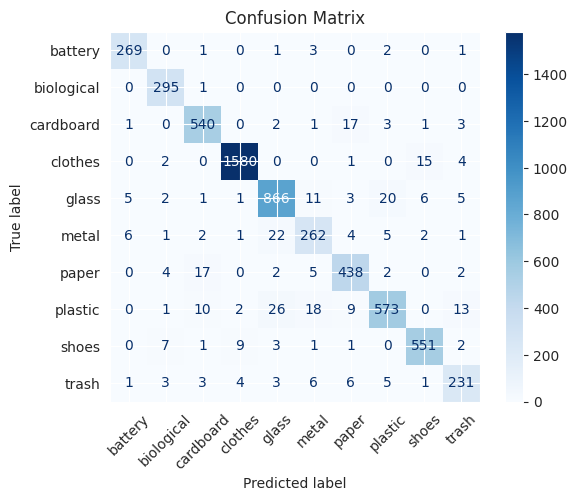

In [ ]:
# Prediksi
Y_pred = model.predict(test_gen)
y_pred = np.argmax(Y_pred, axis=1)
y_true = test_gen.classes
class_labels = list(test_gen.class_indices.keys())

# Classification Report
print("Classification Report:\n")
print(classification_report(y_true, y_pred, target_names=class_labels))

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_labels)
disp.plot(xticks_rotation=45, cmap='Blues')
plt.title("Confusion Matrix")
plt.show()

5929/5929 ━━━━━━━━━━━━━━━━━━━━ 35s 6ms/step
Classification Report:

              precision    recall  f1-score   support

     battery       0.96      0.97      0.97       277
  biological       0.95      1.00      0.97       296
   cardboard       0.96      0.96      0.96       568
     clothes       1.00      0.99      0.99      1602
       glass       0.95      0.96      0.95       920
       metal       0.86      0.89      0.87       306
       paper       0.93      0.93      0.93       470
     plastic       0.95      0.88      0.91       652
       shoes       0.95      0.97      0.96       575
       trash       0.88      0.89      0.88       263

    accuracy                           0.95      5929
   macro avg       0.94      0.94      0.94      5929
weighted avg       0.95      0.95      0.95      5929



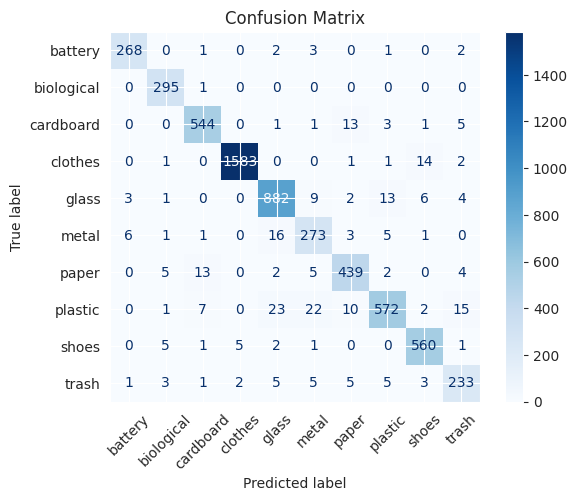

In [ ]:
from tensorflow.keras.models import load_model

# Load model terbaik hasil fine-tuning
model = load_model('best_model_finetuned.h5')

# Prediksi
Y_pred = model.predict(test_gen)
y_pred = np.argmax(Y_pred, axis=1)
y_true = test_gen.classes
class_labels = list(test_gen.class_indices.keys())

# Classification Report
print("Classification Report:\n")
print(classification_report(y_true, y_pred, target_names=class_labels))

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_labels)
disp.plot(xticks_rotation=45, cmap='Blues')
plt.title("Confusion Matrix")
plt.show()


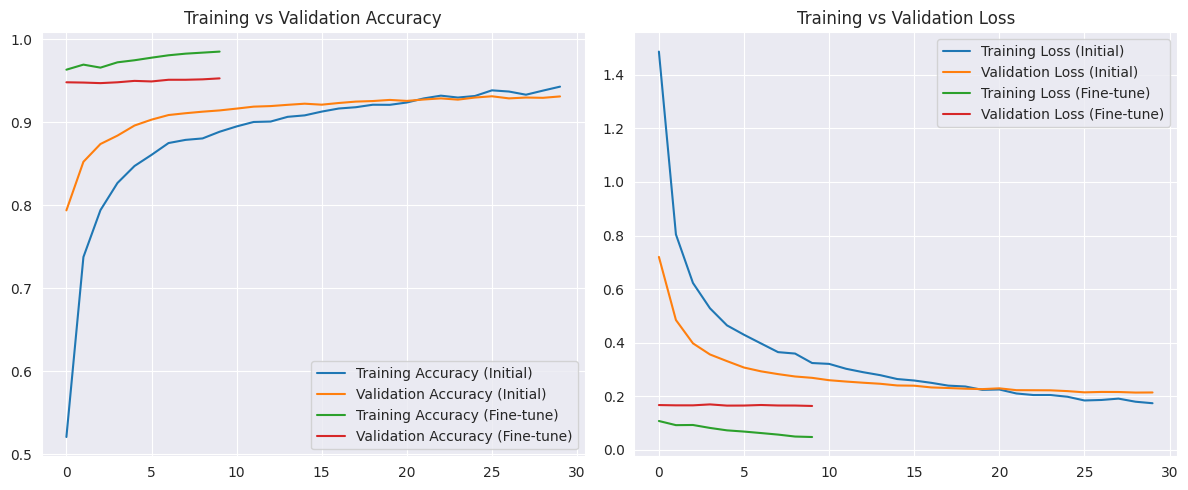

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

# Plot Akurasi
axs[0].plot(history.history['accuracy'], label='Training Accuracy (Initial)')
axs[0].plot(history.history['val_accuracy'], label='Validation Accuracy (Initial)')
axs[0].plot(fine_tune_history.history['accuracy'], label='Training Accuracy (Fine-tune)')
axs[0].plot(fine_tune_history.history['val_accuracy'], label='Validation Accuracy (Fine-tune)')
axs[0].set_title('Training vs Validation Accuracy')
axs[0].legend()

# Plot Loss
axs[1].plot(history.history['loss'], label='Training Loss (Initial)')
axs[1].plot(history.history['val_loss'], label='Validation Loss (Initial)')
axs[1].plot(fine_tune_history.history['loss'], label='Training Loss (Fine-tune)')
axs[1].plot(fine_tune_history.history['val_loss'], label='Validation Loss (Fine-tune)')
axs[1].set_title('Training vs Validation Loss')
axs[1].legend()

plt.tight_layout()
plt.show()


In [ ]:
model.export('/content/saved_model')

from google.colab import files
shutil.make_archive('/content/saved_model', 'zip', '/content/saved_model')
files.download('/content/saved_model.zip')

Saved artifact at '/content/saved_model'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='input_layer_1')
Output Type:
  TensorSpec(shape=(None, 10), dtype=tf.float32, name=None)
Captures:
  133818737548112: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133818737550416: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133818737548880: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133818737548496: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133818737548304: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133818737549264: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133818737551184: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133818737551568: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133818737551376: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133818737547344: TensorSpec(shape=(), dtype=tf.resource, name=None)
  13381873

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
converter = tf.lite.TFLiteConverter.from_saved_model('/content/saved_model')
tflite_model = converter.convert()

with tf.io.gfile.GFile('model.tflite', 'wb') as f:
    f.write(tflite_model)

In [ ]:
class_labels = ['battery', 'biological', 'cardboard', 'clothes', 'glass', 'metal', 'paper', 'plastic', 'shoes', 'trash']

with open('label.txt', 'w') as f:
    for label in class_labels:
        f.write(f"{label}\n")

Silakan upload gambar...


Saving images (2).jpeg to images (2).jpeg

Hasil Prediksi:
battery             : 99.99%
biological          : 0.00%
cardboard           : 0.00%
clothes             : 0.00%
glass               : 0.00%
metal               : 0.00%
paper               : 0.00%
plastic             : 0.00%
shoes               : 0.00%
trash               : 0.00%


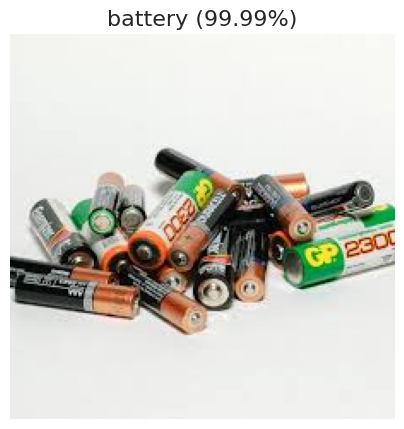

In [ ]:
# Upload gambar
print("Silakan upload gambar...")
uploaded = files.upload()
image_name = next(iter(uploaded))

# Load model TFLite
interpreter = tf.lite.Interpreter(model_path="model.tflite")
interpreter.allocate_tensors()

# Ambil informasi input-output
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

# Fungsi untuk mempersiapkan input
def preprocess(image_path, target_size=(224, 224)):
    img = Image.open(image_path).convert('RGB').resize(target_size)
    img_array = np.array(img, dtype=np.float32) / 255.0
    img_array = np.expand_dims(img_array, axis=0)
    return img_array

# Load daftar label
with open('label.txt', 'r') as f:
    labels = f.read().strip().split('\n')

# Fungsi untuk melakukan prediksi
def predict(image_path):
    input_data = preprocess(image_path)
    interpreter.set_tensor(input_details[0]['index'], input_data)
    interpreter.invoke()
    output_data = interpreter.get_tensor(output_details[0]['index'])[0]
    return output_data

# Jalankan prediksi
scores = predict(image_name)

# Tampilkan semua hasil
print("\nHasil Prediksi:")
for label, score in zip(labels, scores):
    print(f"{label:20}: {score:.2%}")

# Tampilkan gambar dengan prediksi terbaik
best_idx = np.argmax(scores)
best_label = labels[best_idx]
confidence = scores[best_idx]

img = Image.open(image_name)
plt.figure(figsize=(5,5))
plt.imshow(img)
plt.title(f"{best_label} ({confidence:.2%})", fontsize=16)
plt.axis('off')
plt.show()

Silakan upload gambar...


Saving vaatelaja-1280x720.jpg to vaatelaja-1280x720.jpg

Hasil Prediksi:
battery             : 0.00%
biological          : 0.03%
cardboard           : 0.01%
clothes             : 92.99%
glass               : 0.00%
metal               : 0.18%
paper               : 6.01%
plastic             : 0.21%
shoes               : 0.08%
trash               : 0.50%


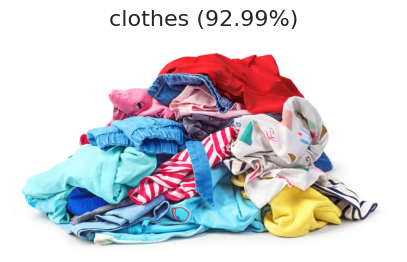

In [ ]:
# Upload gambar
print("Silakan upload gambar...")
uploaded = files.upload()
image_name = next(iter(uploaded))

# Load model TFLite
interpreter = tf.lite.Interpreter(model_path="model.tflite")
interpreter.allocate_tensors()

# Ambil informasi input-output
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

# Fungsi untuk mempersiapkan input
def preprocess(image_path, target_size=(224, 224)):
    img = Image.open(image_path).convert('RGB').resize(target_size)
    img_array = np.array(img, dtype=np.float32) / 255.0
    img_array = np.expand_dims(img_array, axis=0)
    return img_array

# Load daftar label
with open('label.txt', 'r') as f:
    labels = f.read().strip().split('\n')

# Fungsi untuk melakukan prediksi
def predict(image_path):
    input_data = preprocess(image_path)
    interpreter.set_tensor(input_details[0]['index'], input_data)
    interpreter.invoke()
    output_data = interpreter.get_tensor(output_details[0]['index'])[0]
    return output_data

# Jalankan prediksi
scores = predict(image_name)

# Tampilkan semua hasil
print("\nHasil Prediksi:")
for label, score in zip(labels, scores):
    print(f"{label:20}: {score:.2%}")

# Tampilkan gambar dengan prediksi terbaik
best_idx = np.argmax(scores)
best_label = labels[best_idx]
confidence = scores[best_idx]

img = Image.open(image_name)
plt.figure(figsize=(5,5))
plt.imshow(img)
plt.title(f"{best_label} ({confidence:.2%})", fontsize=16)
plt.axis('off')
plt.show()